In [1]:

from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from datetime import timedelta,datetime
import pandas as pd
import numpy as np


In [2]:
#Initializes an Analytics Reporting API

def initialize_analyticsreporting(api_name,api_version,scope ,key_file_location):

  credentials = ServiceAccountCredentials.from_json_keyfile_name(
      key_file_location, scope)
 # Building the service object
  analytics = build(api_name, api_version, credentials=credentials)

  return analytics

#Initializes an  API v3 to get view id
def get_service(api_name, api_version, scopes, key_file_location):

    credentials = ServiceAccountCredentials.from_json_keyfile_name(
            key_file_location, scopes=scopes)
    service = build(api_name, api_version, credentials=credentials)

    return service

#Get First view id
def get_first_profile_id(service):
  
    accounts = service.management().accounts().list().execute()

    if accounts.get('items'):       
        account = accounts.get('items')[0].get('id')

        properties = service.management().webproperties().list(
                accountId=account).execute()

        if properties.get('items'):
            property = properties.get('items')[0].get('id')

            # Get a list of all views (profiles) for the first property.
            profiles = service.management().profiles().list(
                    accountId=account,
                    webPropertyId=property).execute()

            if profiles.get('items'):
               
                return profiles.get('items')[0].get('id')

    return None

#call the api to fetch analytics info
def get_report(analytics,view_id, date, metrics, dimension,segment):

    return analytics.reports().batchGet(
        body={
            'reportRequests': [
                {
                    'viewId': view_id,
                    'dateRanges': date,
                    'metrics': metrics,
                    'dimensions': dimension,
                    'segments': segment,
                    'pageSize': 10000
                }]
        }
    ).execute()
#Convert json to dataframe
def to_dataframe(response):
  
    # extracting  Data
    for report in response.get('reports', []):

        columnHeader = report.get('columnHeader', {})
        dimensionHeader = columnHeader.get('dimensions', [])
        metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
        rows = report.get('data', {}).get('rows', [])

        df_columns = dimensionHeader + [head['name'] for head in metricHeaders]
        df_rows = []
        
        for row in rows:
            dimension = row.get('dimensions', [])
            dateRangeValues = row.get('metrics', [])[0].get('values', [])
            
            df_row = dimension + [value for value in dateRangeValues]
            df_rows.append(df_row)
            
    return pd.DataFrame(df_rows, columns = df_columns)


In [6]:
# Define the init params
scope = 'https://www.googleapis.com/auth/analytics.readonly'
key_file_location = r'D:\COBOT Systems\meeracobot-ca6f394b0091.json'

 # Call to get the view id.
service = get_service(api_name='analytics',api_version='v3',scopes=[scope],key_file_location=key_file_location)
view_id = get_first_profile_id(service)

#Initialize analytics api
analytics = initialize_analyticsreporting(api_name ='analyticsreporting',api_version='v4',scope=scope,key_file_location=key_file_location)

# analysis 1 Browser Type vs Sessions
date = [{'startDate': datetime.strftime(datetime.now() - timedelta(days = 90),'%Y-%m-%d'),
          'endDate': datetime.strftime(datetime.now(),'%Y-%m-%d')}]
metrics = [{'expression': 'ga:sessions'}]
dimension = [{'name': 'ga:browser'}]
segment = []
response = get_report(analytics, view_id,date, metrics, dimension,segment)
df_browser_sessions = to_dataframe(response)
df_browser_sessions.rename(columns = {"ga:browser":"Browser", "ga:sessions":"Sessions"}, inplace="True")
df_browser_sessions['Sessions'] = df_browser_sessions.Sessions.astype(int)
df_browser_sessions = df_browser_sessions.sort_values(by=['Sessions'], ascending=False)

# analysis 2 Medium vs Sessions
date = [{'startDate': datetime.strftime(datetime.now() - timedelta(days = 90),'%Y-%m-%d'),
          'endDate': datetime.strftime(datetime.now(),'%Y-%m-%d')}]
metrics = [{'expression': 'ga:sessions'}]
dimension = [{'name': 'ga:medium'}]
segment = []
response = get_report(analytics, view_id,date, metrics, dimension,segment)
df_medium_sessions = to_dataframe(response)
df_medium_sessions.rename(columns = {"ga:medium":"Medium", "ga:sessions":"Sessions"}, inplace="True")
df_medium_sessions['Sessions'] = df_medium_sessions.Sessions.astype(int)
df_medium_sessions = df_medium_sessions.sort_values(by=['Sessions'], ascending=False)
# analysis 3 Country vs Sessions
date = [{'startDate': datetime.strftime(datetime.now() - timedelta(days = 90),'%Y-%m-%d'),
          'endDate': datetime.strftime(datetime.now(),'%Y-%m-%d')}]
metrics = [{'expression': 'ga:sessions'}]
dimension = [{'name': 'ga:country'}]
segment = []
response = get_report(analytics, view_id,date, metrics, dimension,segment)
df_country_sessions = to_dataframe(response)
df_country_sessions.rename(columns = {"ga:country":"Country", "ga:sessions":"Sessions"}, inplace="True")
df_country_sessions['Sessions'] = df_country_sessions.Sessions.astype(int)
df_country_sessions = df_country_sessions.sort_values(by=['Sessions'], ascending=False)
# analysis 4 Calendar Week vs Sessions
date = [{'startDate': datetime.strftime(datetime.now() - timedelta(days = 90),'%Y-%m-%d'),
          'endDate': datetime.strftime(datetime.now(),'%Y-%m-%d')}]
metrics = [{'expression': 'ga:sessions'},{'expression': 'ga:users'}]
dimension = [{'name': 'ga:week'}]
segment = []
response = get_report(analytics, view_id,date, metrics, dimension,segment)
df_week_sessions = to_dataframe(response)
df_week_sessions.rename(columns = {"ga:week":"Week", "ga:sessions":"Sessions"}, inplace="True")
df_week_sessions['Sessions'] = df_week_sessions.Sessions.astype(int)
df_week_sessions = df_week_sessions.sort_values(by=['Week'])


# analysis 5 Device vs Sessions
date = [{'startDate': datetime.strftime(datetime.now() - timedelta(days = 90),'%Y-%m-%d'),
          'endDate': datetime.strftime(datetime.now(),'%Y-%m-%d')}]
metrics = [{'expression': 'ga:sessions'},{'expression': 'ga:avgSessionDuration'}]
dimension = [{'name': 'ga:deviceCategory'}]
segment = []
response = get_report(analytics, view_id,date, metrics, dimension,segment)
df_device_sessions = to_dataframe(response)
df_device_sessions.rename(columns = {"ga:deviceCategory":"deviceCategory", "ga:sessions":"Sessions","ga:avgSessionDuration":"avgSessionDuration"}, inplace="True")
df_device_sessions = df_device_sessions.sort_values(by=['Sessions'])
df_device_sessions['avgSessionDuration'] = df_device_sessions.avgSessionDuration.astype(float)
df_device_sessions['Sessions'] = df_device_sessions.Sessions.astype(int)
df_device_sessions['avgSessionDuration'] = df_device_sessions['avgSessionDuration'].round(2)

# analysis 6 pagepath
date = [{'startDate': datetime.strftime(datetime.now() - timedelta(days = 90),'%Y-%m-%d'),
          'endDate': datetime.strftime(datetime.now(),'%Y-%m-%d')}]
metrics = [{'expression': 'ga:pageLoadTime'},{'expression': 'ga:sessions'}]
dimension = [{'name': 'ga:pagePath'},{'name': 'ga:dayofweek'}]
segment = []
response = get_report(analytics, view_id,date, metrics, dimension,segment)
df_pageviews_path = to_dataframe(response)
df_pageviews_path.rename(columns = {"ga:pageLoadTime":"pageLoadTime", "ga:pagePath":"PagePath","ga:dayofweek":"dayofweek","ga:sessions":"sessions"}, inplace="True")

df_pageviews_path['pageLoadTime'] = df_pageviews_path.pageLoadTime.astype(int)
df_pageviews_path = df_pageviews_path.sort_values(by=['dayofweek'])
new_data = { "0":"Sun",
             "1":"Mon",
             "2":"Tue",
             "3":"Wed",
             "4":"Thu" ,
           "5":"Fri",
           "6":"Sat"}
df_pageviews_path["dayofweek"] = df_pageviews_path["dayofweek"].map(new_data)


In [15]:
#Export datafarme and excel and do charting and formatting
excel_file = r'D:\COBOT Systems\Cobotsystemstats.xlsx'
writer = pd.ExcelWriter(excel_file, engine='xlsxwriter')

#####################################
#Exporting Calendar Week vs Sessions from dataframe to excel 

sheet_name = 'Week Wise Stat'
df_week_sessions.to_excel(writer, sheet_name=sheet_name,index=False)
rows = df_week_sessions.count()[0] 
workbook = writer.book
worksheet = writer.sheets[sheet_name]
chart1 = workbook.add_chart({'type': 'line'})
chart1.set_title({'name': 'Calendar Week vs Sessions'})
chart1.add_series({
        'categories' : ['Week Wise Stat', 1, 0, rows, 0],
       'values':     ['Week Wise Stat', 1, 1, rows, 1],
     
    'marker': {'type': 'diamond','fill':   {'color': 'red'}},
    'data_labels': {'value': True}
    })
chart1.set_x_axis({'name': 'Calendar Week'})
chart1.set_y_axis({'name': 'Sessions', 'major_gridlines': {'visible': False}})
chart1.set_legend({'position': 'none'})
worksheet.insert_chart('F3', chart1,{'x_scale': 2, 'y_scale': 2})

#####################################
#Exporting  Browser Type vs Sessions from dataframe to excel 

sheet_name = 'Browser Stat'

df_browser_sessions.to_excel(writer, sheet_name=sheet_name,index=False)
rows = df_browser_sessions.count()[0]

workbook = writer.book
worksheet = writer.sheets[sheet_name]

chart1 = workbook.add_chart({'type': 'column'})
chart1.set_title({'name': 'Browser Type vs Sessions'})
chart1.add_series({
        'categories' : ['Browser Stat', 1, 0, rows, 0],
       'values':     ['Browser Stat', 1, 1, rows, 1],
    'gap':        2,
    'data_labels': {'value': True}

    })


chart1.set_x_axis({'name': 'Browser'})
chart1.set_y_axis({'name': 'Sessions', 'major_gridlines': {'visible': False}})

chart1.set_legend({'position': 'none'})

worksheet.insert_chart('F3', chart1,{'x_scale': 3, 'y_scale': 2})

#####################################
#Exporting Medium vs Sessions from dataframe to excel 

sheet_name = 'Medium Stat'
df_medium_sessions.to_excel(writer, sheet_name=sheet_name,index=False)
rows = df_medium_sessions.count()[0] 
workbook = writer.book
worksheet = writer.sheets[sheet_name]
# Create a chart object.
chart1 = workbook.add_chart({'type': 'pie'})

chart1.add_series({
     
        'categories' : ['Medium Stat', 1, 0, rows, 0],
       'values':     ['Medium Stat', 1, 1, rows, 1],
        'gap':        2,
    'data_labels': {'percentage': True},
    
    })

chart1.set_title({'name': 'Medium vs Sessions'})
chart1.set_style(10)
chart1.set_x_axis({'name': 'Medium'})
chart1.set_y_axis({'name': 'Sessions', 'major_gridlines': {'visible': False}})
worksheet.insert_chart('F3', chart1,{'x_scale': 2, 'y_scale': 2})


#####################################
#Exporting Device vs Sessions from dataframe to excel 

sheet_name = 'Device Stat'
df_device_sessions.to_excel(writer, sheet_name=sheet_name,index=False)
rows = df_device_sessions.count()[0]
   
workbook = writer.book
worksheet = writer.sheets[sheet_name]

# Create a chart object.
chart1 = workbook.add_chart({'type': 'pie'})

chart1.add_series({
     
        'categories' : ['Device Stat', 1, 0, rows, 0],
       'values':     ['Device Stat', 1, 1, rows, 1],
        'gap':        2,
    'data_labels': {'percentage': True}
    })

chart1.set_title({'name': 'Device vs Sessions'})
chart1.set_style(10)
chart1.set_x_axis({'name': 'Device'})
chart1.set_y_axis({'name': 'Sessions', 'major_gridlines': {'visible': False}})

worksheet.insert_chart('F3', chart1,{'x_scale': 1, 'y_scale': 1})

chart2 = workbook.add_chart({'type': 'pie'})


chart2.add_series({
     
        'categories' : ['Device Stat', 1, 0, rows, 0],
       'values':     ['Device Stat', 1, 2, rows, 2],
        'gap':        2,
    'data_labels': {'percentage': True}
    })

chart2.set_title({'name': 'Device vs AvgSession Time'})

chart2.set_x_axis({'name': 'Device'})
chart1.set_y_axis({'name': 'AvgSession Time', 'major_gridlines': {'visible': False}})

worksheet.insert_chart('F25', chart2,{'x_scale': 1, 'y_scale': 1})

#####################################
#Exporting PagePath from dataframe to pivot table 
sheet_name = 'Pageview Stat'
rows = df_pageviews_path.count()[0]

table = pd.pivot_table(df_pageviews_path,index=["PagePath"], 
                       columns =['dayofweek'],values=["sessions"],aggfunc=[np.sum],fill_value=0)

table.to_excel(writer,sheet_name)
workbook = writer.book
worksheet = writer.sheets[sheet_name]
worksheet.set_column(0, 0, 100)
cell_format = workbook.add_format()
cell_format.set_bg_color('gray')
cell_format.set_bold(True)
cell_format.set_underline()
cell_format.set_center_across()
worksheet.write('A3', 'day of week', cell_format)
worksheet.write('A4', 'Path in the Site', cell_format)
worksheet.write('B1', '', cell_format)
worksheet.write('B2', 'Sessions', cell_format)




#####################################
#Exporting Country vs Sessions from dataframe to excel 
sheet_name = 'Country Stat'
df_country_sessions.to_excel(writer, sheet_name=sheet_name,index=False)
rows = df_country_sessions.count()[0]

workbook = writer.book
worksheet = writer.sheets[sheet_name]

chart1 = workbook.add_chart({'type': 'column'})


chart1.set_title({'name': 'Country vs Sessions'})
chart1.add_series({
        'categories' : ['Country Stat', 1, 0, rows, 0],
       'values':     ['Country Stat', 1, 1, rows, 1],
        'gap':        2,
    'data_labels': {'value': True}
    })

chart1.set_x_axis({'name': 'Country'})
chart1.set_y_axis({'name': 'Sessions', 'major_gridlines': {'visible': False}})
chart1.set_legend({'position': 'none'})
worksheet.insert_chart('F3', chart1,{'x_scale': 3, 'y_scale': 2})

writer.save()

<AxesSubplot:title={'center':'Week vs Sessions'}, xlabel='Week'>

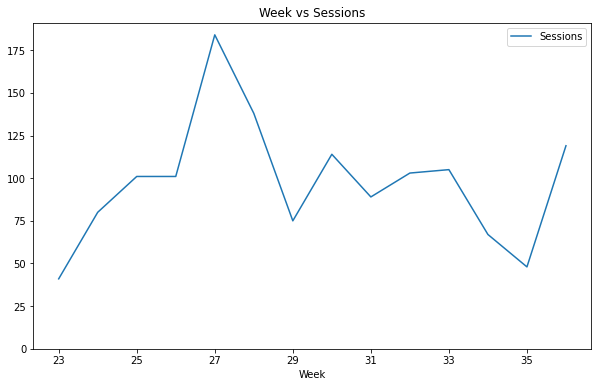

In [9]:
df_week_sessions.plot.line(title = 'Week vs Sessions',x='Week', y=['Sessions'], ylim=[0,None], figsize=[10, 6])

<AxesSubplot:title={'center':'Browser vs Sessions'}, xlabel='Browser'>

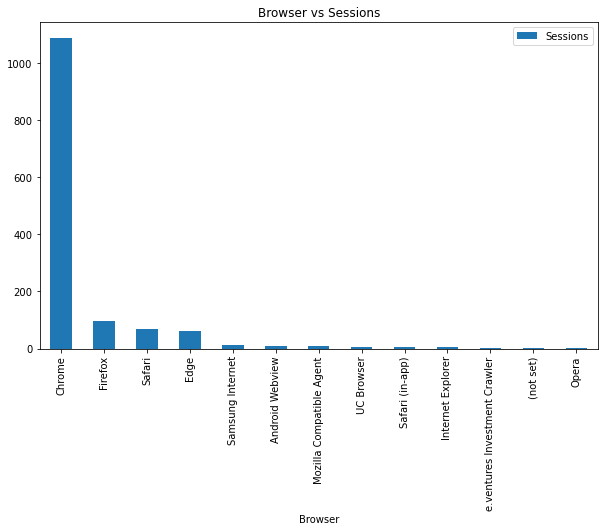

In [10]:
df_browser_sessions.plot.bar(title = 'Browser vs Sessions',x='Browser', y=['Sessions'], ylim=[0,None], figsize=[10, 6])

<AxesSubplot:title={'center':'Medium vs Sessions'}, ylabel='Sessions'>

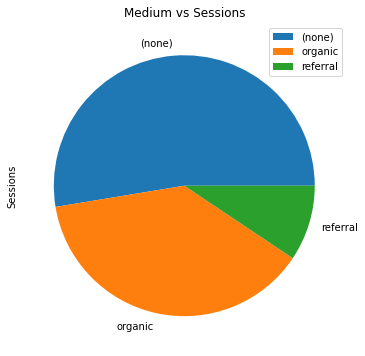

In [11]:
df_medium_sessions.plot.pie( title = 'Medium vs Sessions',labels = df_medium_sessions['Medium'], y='Sessions', figsize=[10, 6])

<AxesSubplot:title={'center':'Device vs avgSessionDuration'}, ylabel='avgSessionDuration'>

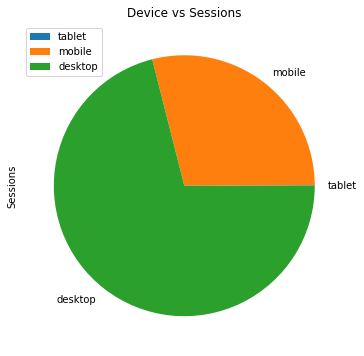

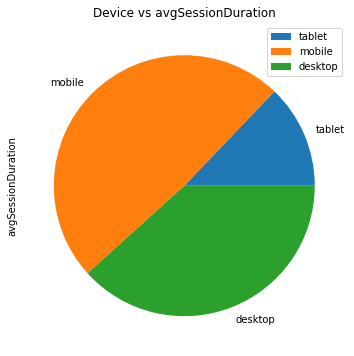

In [9]:
df_device_sessions.plot.pie( title = 'Device vs Sessions',labels = df_device_sessions['deviceCategory'], y='Sessions', figsize=[10, 6])
df_device_sessions.plot.pie( title = 'Device vs avgSessionDuration',labels = df_device_sessions['deviceCategory'], y='avgSessionDuration', figsize=[10, 6])

<AxesSubplot:title={'center':'Country vs Sessions'}, xlabel='Country'>

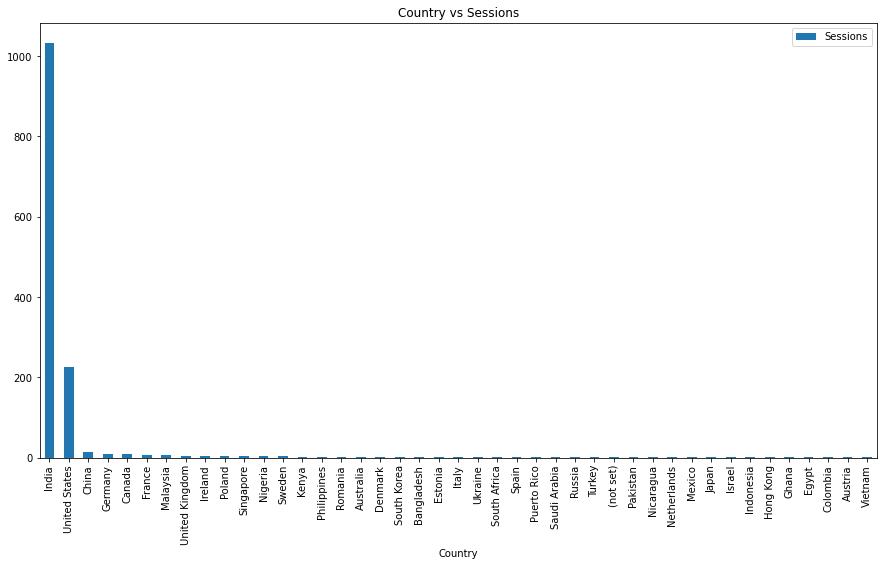

In [14]:

df_country_sessions.plot.bar(title = 'Country vs Sessions',x='Country', y=['Sessions'], ylim=[0,None], figsize=[15, 8])


In [11]:
table

sum                    \
                                                   sessions                     
dayofweek                                               Fri  Mon Sat Sun  Thu   
PagePath                                                                        
/                                                       126  119  72  42  134   
/- Extract the data using the Google Analytics ...        0    0   0   0    1   
/?fbclid=IwAR0JENnxiv696u_PoMWyr0RzWGyFDrJTyq1e...        0    0   0   0    1   
/?fbclid=IwAR0JaEs9geSed-NB7fib8UrHV1F3zY9owEil...        0    0   0   0    1   
/INDX                                                     1    0   0   0    0   
/article/how-to-explore-starting-a-career-in-an...        0    0   1   0    1   
/article/how-to-explore-starting-a-career-in-an...        1    1   1   0    1   
/article/how-to-get-an-entry-level-job-as-an-ai...        2    0   3   0    2   
/article/the-data-science-internship-challenge-...       13   13  23   5    3   
/article/the-data-science-internship-challenge-...        1    0   0   1    0   
/automate-decision-analytics-system-en-us.htm             0    1   0   0    1   
/b2b-sales-operations-excellence-en-us.htm                2    3   1   1    3   
/careers-en-us.htm                                       27   47  25  27   43   
/careers-en-us.htm?navBarVisibility=false                 0    4   0   0    0   
/cobot-systems-for-decision-analytics-en-us.htm           5    0   1   0    2   
/cobot-systems-solutions-overview-en-us.htm               1    0   1   0    0   
/cobots-in-the-bi-and-analytics-systems-context...        1    0   1   0    3   
/deployment-options-en-us.htm                             1    0   1   0    0   
/design-decision-analytics-architecture-en-us.htm         4    5   4   1    8   
/finance-operations-excellence-en-us.htm                  1    0   1   0    0   
/hightech-services-operations-excellence-en-us.htm        1    0   1   0    0   
/hr-operations-excellence-en-us.htm                       1    0   1   1    0   
/innovate-decision-analytics-talent-en-us.htm             1    1   1   0    0   
/leadership-en-us.htm                                     1    0   1   1    3   
/locations-cobot-systems--india-en-us.htm                 1    0   0   0    0   
/locations-cobot-systems--usa-en-us.htm                   2    1   0   2    3   
/operate-decision-analytics-center-en-us.htm              1    0   1   0    1   
/platform-en-us.htm                                       2    0   1   0    0   
/sitemap-en-us.htm                                        0    0   0   0    1   
/what-is-a-cobot-en-us.htm                                2    4   5   0    9   

                                                              
                                                              
dayofweek                                           Tue  Wed  
PagePath                                                      
/                                                   191  130  
/- Extract the data using the Google Analytics ...    0    0  
/?fbclid=IwAR0JENnxiv696u_PoMWyr0RzWGyFDrJTyq1e...    0    0  
/?fbclid=IwAR0JaEs9geSed-NB7fib8UrHV1F3zY9owEil...    0    0  
/INDX                                                 0    0  
/article/how-to-explore-starting-a-career-in-an...    0    0  
/article/how-to-explore-starting-a-career-in-an...    5    2  
/article/how-to-get-an-entry-level-job-as-an-ai...    2    3  
/article/the-data-science-internship-challenge-...    8    7  
/article/the-data-science-internship-challenge-...    0    4  
/automate-decision-analytics-system-en-us.htm         0    3  
/b2b-sales-operations-excellence-en-us.htm            3    1  
/careers-en-us.htm                                   56   48  
/careers-en-us.htm?navBarVisibility=false             1    0  
/cobot-systems-for-decision-analytics-en-us.htm       2    0  
/cobot-systems-solutions-overview-en-us.htm           2    0  
/cobots-in-the-bi-and-analytics-systems-c